# VaR Computations

In this project, we will consider a portfolio solely composed of the Natixis stock.

###### 1 - Import the librairies and the data 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np
import math
import random

In [2]:
data = pd.read_csv("Natixis.txt",header = None,sep='\t',decimal = ',',parse_dates=True)
data.columns = ('Date','Price')
data['Date'] = pd.to_datetime(data['Date'],format='%d/%m/%Y')
data['Price'] = data['Price'].astype(float)
data['Returns'] = data['Price'].pct_change(1) #Daily returns

In [3]:
data.head()

,Date,Price,Returns
0,2015-01-02,5.621,NaN
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836


Text(0, 0.5, 'Returns (%)')

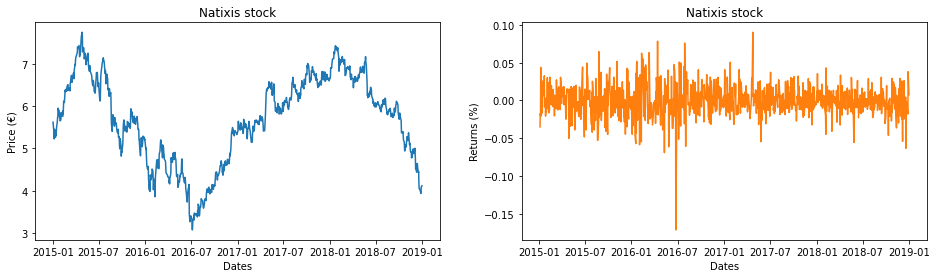

In [58]:
fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(data['Date'],data['Price'],color = "C0")
ax[0].set_title("Natixis stock")
ax[0].set_xlabel("Dates")
ax[0].set_ylabel("Price (€)")

ax[1].plot(data['Date'],data['Returns'],color = "C1")
ax[1].set_title("Natixis stock")
ax[1].set_xlabel("Dates")
ax[1].set_ylabel("Returns (%)")

###### 2 - Historical VaR

To compute the historical VaR, we consider the historical distribution of the daily returns of the portfolio and assume that this distribution will remain the same in the close future. We then pick a quantile of this distribution at the desired confidence level and we obtain the Value at Risk of the portfolio.

In [5]:
I = 1000 #Initial investment
p = 0.95 #Confidence level

hist_VaR = np.quantile(sorted(data['Returns'].dropna()),1 - p)
print(f"The historical VaR is equal to : {hist_VaR}")

The historical VaR is equal to : -0.03174235675624811


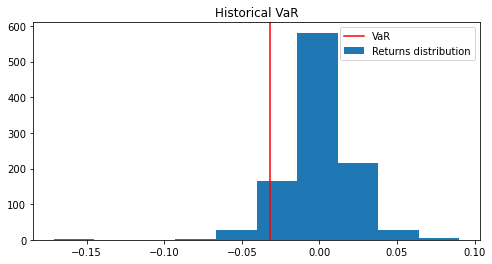

In [6]:
plt.figure(figsize=(8,4))
plt.hist(data['Returns'],label="Returns distribution")
plt.axvline(hist_VaR,color = 'red',label="VaR")
plt.title("Historical VaR")
plt.legend()

In [7]:
print(f"If we invested I = {I} € in the portfolio,",
      f"we expect to lose less than {np.round(-hist_VaR * I,2)}€",
      f"at a 1 day horizon with a probability of {p}") 

If we invested I = 1000 € in the portfolio, we expect to lose less than 31.74€ at a 1 day horizon with a probability of 0.95


###### 3 - Parametric VaR 

In the parametric VaR approach, we first compute the expectation and the standard deviation of the portfolio returns. We then assume that the portfolio's returns follow a gaussian distribution and we pick a quantile in this distribution to compute the parametric VaR.

In [8]:
mu = np.mean(data['Returns'])
sigma = np.std(data['Returns'])
gaussian_density = np.random.normal(mu, sigma, 1000)
print(f"Mean = {mu} | Standard deviation = {sigma}")

Mean = -9.696604801149446e-05 | Standard deviation = 0.020275787615200165


In [9]:
I = 1000 #Initial investment
p = 0.95 #Confidence level

parametric_VaR = np.quantile(gaussian_density,1 - p)
print(f"The parametric VaR is equal to : {parametric_VaR}")

The parametric VaR is equal to : -0.03299818106798515


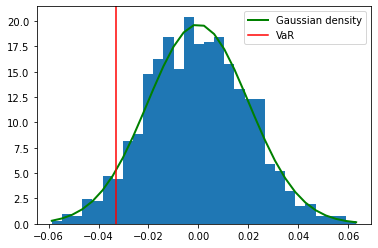

In [10]:
count, bins, ignored = plt.hist(gaussian_density, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='g',label="Gaussian density")
plt.axvline(parametric_VaR,color = 'r',label="VaR")
plt.legend()
plt.show()

In [11]:
print(f"If we invested I = {I} € in the portfolio,",
      f"we expect to lose less than {np.round(-parametric_VaR * I,2)}€",
      f"at a 1 day horizon with a probability of {p}") 

If we invested I = 1000 € in the portfolio, we expect to lose less than 33.0€ at a 1 day horizon with a probability of 0.95


###### 4 - Non-parametric VaR 

In the non-parametric approach, we do not make any assumptions about the data. We estimate a probability distribution of the returns with the kernel density.

In [12]:
def density(x): #Gaussian density
    return (1 / (np.sqrt(2 * np.pi))) * np.exp(-(x**2)/2)

def Kernel_pdf(x,h,obs): #Kernel density function based on a probability density
    cum_sum = 0.0
    n = len(obs)
    
    for i in range(n):
        cum_sum += density((x - obs[i])/h)
         
    return (1 / (n * h)) *  cum_sum

def Kernel_cdf(x,h,obs): #Kernel cumulative distribution function
    cum_sum = 0.0
    n = len(obs)
    
    for i in range(n):
        y = (x - obs[i])/h
        cum_sum += (1 + math.erf(y / np.sqrt(2.0))) / 2.0
        
    return cum_sum / n

In [13]:
#We test with multiple smoothing parameters
h1 = 0.01
h2 = 0.003
h3 = 0.001
n = len(data['Returns'])
obs = sorted(data['Returns'].dropna())
fx1 = []
fx2 = []
fx3 = []

for x in obs:
    fx1.append(Kernel_cdf(x,h1,obs))
    fx2.append(Kernel_cdf(x,h2,obs))
    fx3.append(Kernel_cdf(x,h3,obs))

We estimate the non-parametric VaR by picking a quantile of the Kernel cumulative distribution function.

In [14]:
non_param_VaR = -np.quantile(fx1,1 - p)
print(f"The parametric VaR is equal to : {non_param_VaR}")

The parametric VaR is equal to : -0.06686345269066904


In [15]:
d1 = []
d2 = []
d3 = []

for x in obs:
    d1.append(Kernel_pdf(x,h1,obs))
    d2.append(Kernel_pdf(x,h2,obs))
    d3.append(Kernel_pdf(x,h3,obs))

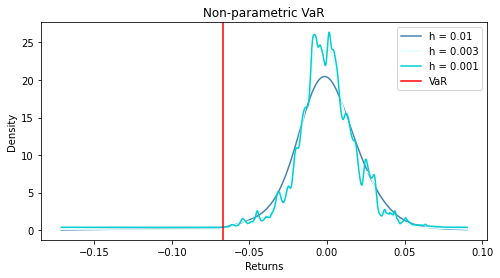

In [57]:
plt.figure(figsize=(8,4))

plt.plot(obs,d1,color="steelblue",label=f"h = {h1}")
plt.plot(obs,d2,color="lightcyan",label=f"h = {h2}")
plt.plot(obs,d3,color = "darkturquoise",label=f"h = {h3}")

plt.axvline(x=non_param_VaR,color="red",label="VaR")

plt.title("Non-parametric VaR")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

In [17]:
print(f"If we invested I = {I} € in the portfolio,",
      f"we expect to lose less than {np.round(-non_param_VaR * I,2)}€",
      f"at a 1 day horizon with a probability of {p}")

If we invested I = 1000 € in the portfolio, we expect to lose less than 66.86€ at a 1 day horizon with a probability of 0.95


###### 5 - Monte Carlo VaR 

In the Monte Carlo approach, we simulate a large number of stock prices paths using the geometric brownian motion. We then obtain a probability distribution of the prices at a one day horizon and we can compute the Monte Carlo VaR by picking a quantile in the new returns distribution.

In [123]:
def GBM(mu,sigma,dt): #Geometric Brownian Motion for prices
    drift = (mu - 0.5 * sigma ** 2) * dt/252 #Stock price drift
    a = sigma * np.sqrt(dt/252) #Stochastic term
    r = np.random.normal(0,1)
    return np.exp(drift + a * r)

In [124]:
mu = np.mean(data['Returns']) #drift
sigma = np.std(data['Returns'])
t = np.arange(0,1000)
S0 = data['Price'].iloc[-1]
n_sim = 1000
dt = 1 #1 day

In [125]:
S = [] #Simulated prices
for i in range(n_sim):
    S.append(S0 * GBM(mu,sigma,dt))

In [126]:
prices = data['Price'].tolist()
dates = data['Date'].tolist()
dates.append(dates[-1])
dates[-1] += datetime.timedelta(days=1)

([<matplotlib.axis.XTick at 0x240a43961f0>,
 [Text(0, 0, ''), Text(0, 0, '')])

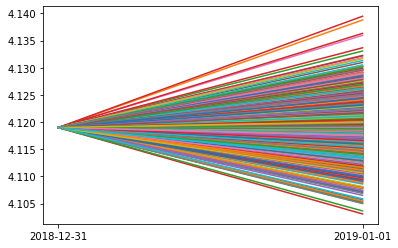

In [127]:
prices.append(0) #Price in t + 1
for sim in S:
    prices[-1] = sim
    plt.plot(dates[-2:],prices[-2:])
plt.xticks([dates[-2],dates[-1]])

In [128]:
sim_returns = [(S[t] - S[t - 1]) / S[t - 1] for t,sim in enumerate(S[1:])] #Simulated returns at a one day horizon

In [129]:
mc_VaR = np.quantile(sorted(sim_returns),1 - p)
print(f"The Monte Carlo VaR is equal to : {mc_VaR }")

The Monte Carlo VaR is equal to : -0.003022508751134258


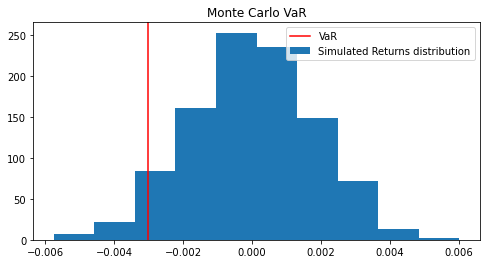

In [130]:
plt.figure(figsize=(8,4))
plt.hist(sim_returns,label="Simulated Returns distribution")
plt.axvline(mc_VaR,color = 'red',label="VaR")
plt.title("Monte Carlo VaR")
plt.legend()

In [131]:
print(f"If we invested I = {I} € in the portfolio,",
      f"we expect to lose less than {np.round(-mc_VaR * I,2)}€",
      f"at a 1 day horizon with a probability of {p}") 

If we invested I = 1000 € in the portfolio, we expect to lose less than 3.02€ at a 1 day horizon with a probability of 0.95
